In [1]:
pip install numpy pandas matplotlib

In [2]:
!pip install torch-fidelity

In [3]:
pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 19.5 MB/s eta 0:00:00


In [4]:
pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.0 MB/s eta 0:00:00


In [5]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from math import log2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision
from torchmetrics.image.fid import FrechetInceptionDistance
import lpips
import csv

In [ ]:
# Constants
DATASET = 'STYLEGAN/STYLEGAN/train'
START_TRAIN_IMG_SIZE = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LEARNING_RATE = 1e-3
BATCH_SIZES = [256, 256, 128, 64, 32, 16]
CHANNELS_IMG = 3
Z_DIM = 512
W_DIM = 512
IN_CHANNELS = 512
LAMBDA_GP = 10
PROGRESSIVE_EPOCHS = [40] * len(BATCH_SIZES)

# Tracking losses
loss_gen_list = []
loss_critic_list = []

def get_loader(image_size):
    transform = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize(
                [0.5 for _ in range(CHANNELS_IMG)],
                [0.5 for _ in range(CHANNELS_IMG)],
            ),
        ]
    )
    batch_size = BATCH_SIZES[int(log2(image_size / 4))]
    dataset = datasets.ImageFolder(root=DATASET, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader, dataset

# Noice apping network
# AdaIN
# Progressice growing
factors = [1,1,1,1/2,1/4,1/8,1/16,1/32]

In [6]:


class WSLinear(nn.Module):
    def __init__(
        self, in_features, out_features
    ):
        super(WSLinear,self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.scale  = (2/in_features) ** 0.5
        self.bias   = self.linear.bias
        self.linear.bias = None

        nn.init.normal_(self.linear.weight)
        nn.init.zeros_(self.bias)

    def forward(self,x):
        return self.linear(x * self.scale) + self.bias
class PixenNorm(nn.Module):
    def __init__(self):
        super(PixenNorm, self).__init__()
        self.epsilon = 1e-8
    def forward(self,x ):
        return x / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True)+  self.epsilon)
class MappingNetwork(nn.Module):
    def __init__(self, z_dim, w_dim):
        super().__init__()
        self.mapping = nn.Sequential(
            PixenNorm(),
            WSLinear(z_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
        )

    def forward(self,x):
        return self.mapping(x)

In [7]:
class AdaIN(nn.Module):
    def __init__(self, channels, w_dim):
        super().__init__()
        self.instance_norm = nn.InstanceNorm2d(channels)
        self.style_scale   = WSLinear(w_dim, channels)
        self.style_bias    = WSLinear(w_dim, channels)

    def forward(self,x,w):
        x = self.instance_norm(x)
        style_scale = self.style_scale(w).unsqueeze(2).unsqueeze(3)
        style_bias  = self.style_bias(w).unsqueeze(2).unsqueeze(3)
        return style_scale * x + style_bias
class injectNoise(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1,channels,1,1))

    def forward(self, x):
        noise = torch.randn((x.shape[0], 1, x.shape[2], x.shape[3]), device = x.device)
        return x + self.weight + noise
class GenBlock(nn.Module):
    def __init__(self, in_channel, out_channel, w_dim):
        super(GenBlock, self).__init__()
        self.conv1 = WSConv2d(in_channel, out_channel)
        self.conv2 = WSConv2d(out_channel, out_channel)
        self.leaky = nn.LeakyReLU(0.2, inplace=True)
        self.inject_noise1 = injectNoise(out_channel)
        self.inject_noise2 = injectNoise(out_channel)
        self.adain1 = AdaIN(out_channel, w_dim)
        self.adain2 = AdaIN(out_channel, w_dim)
    def forward(self, x,w):
        x = self.adain1(self.leaky(self.inject_noise1(self.conv1(x))), w)
        x = self.adain2(self.leaky(self.inject_noise2(self.conv2(x))), w)
        return x
class Generator(nn.Module):
    def __init__(self, z_dim, w_dim, in_channels, img_channels=3):
        super().__init__()
        self.starting_cte = nn.Parameter(torch.ones(1, in_channels, 4,4))
        self.map = MappingNetwork(z_dim, w_dim)
        self.initial_adain1 = AdaIN(in_channels, w_dim)
        self.initial_adain2 = AdaIN(in_channels, w_dim)
        self.initial_noise1 = injectNoise(in_channels)
        self.initial_noise2 = injectNoise(in_channels)
        self.initial_conv   = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.leaky          = nn.LeakyReLU(0.2, inplace=True)

        self.initial_rgb    = WSConv2d(
            in_channels, img_channels, kernel_size = 1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb])
        )

        for i in range(len(factors)-1):
            conv_in_c  = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i+1])
            self.prog_blocks.append(GenBlock(conv_in_c, conv_out_c, w_dim))
            self.rgb_layers.append(WSConv2d(conv_out_c, img_channels, kernel_size = 1, stride=1, padding=0))

    def fade_in(self, alpha, upscaled, generated):
        return torch.tanh(alpha * generated + (1-alpha ) * upscaled)

    def forward(self, noise, alpha, steps):
        w = self.map(noise)
        x = self.initial_adain1(self.initial_noise1(self.starting_cte),w)
        x = self.initial_conv(x)
        out = self.initial_adain2(self.leaky(self.initial_noise2(x)), w)

        if steps == 0:
            return self.initial_rgb(x)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode = 'bilinear')
            out      = self.prog_blocks[step](upscaled,w)

        final_upscaled = self.rgb_layers[steps-1](upscaled)
        final_out      = self.rgb_layers[steps](out)

        return self.fade_in(alpha, final_upscaled, final_out)
class WSConv2d(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (2 / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.leaky(self.conv2(x))
        return x
class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

Current image size: 4
Epoch [1/40]


100%|██████████| 40/40 [00:54<00:00,  1.35s/it, gp=3.74, loss_critic=-219]  


Epoch [2/40]


100%|██████████| 40/40 [00:53<00:00,  1.34s/it, gp=4.83, loss_critic=-17.3]


Epoch [3/40]


100%|██████████| 40/40 [00:53<00:00,  1.33s/it, gp=1.64, loss_critic=-21.5]


Epoch [4/40]


100%|██████████| 40/40 [00:54<00:00,  1.36s/it, gp=0.79, loss_critic=-19.6]


Epoch [5/40]


100%|██████████| 40/40 [00:54<00:00,  1.36s/it, gp=0.777, loss_critic=-10.6]


Epoch [6/40]


100%|██████████| 40/40 [00:53<00:00,  1.34s/it, gp=0.618, loss_critic=-2.96]


Epoch [7/40]


100%|██████████| 40/40 [00:52<00:00,  1.32s/it, gp=0.639, loss_critic=-24.2]


Epoch [8/40]


100%|██████████| 40/40 [00:52<00:00,  1.32s/it, gp=0.505, loss_critic=-10.1]


Epoch [9/40]


100%|██████████| 40/40 [00:52<00:00,  1.32s/it, gp=0.665, loss_critic=-15.3]


Epoch [10/40]


100%|██████████| 40/40 [00:53<00:00,  1.33s/it, gp=0.532, loss_critic=-15.4]


Epoch [11/40]


100%|██████████| 40/40 [00:52<00:00,  1.32s/it, gp=0.587, loss_critic=-24.2]


Epoch [12/40]


100%|██████████| 40/40 [00:52<00:00,  1.32s/it, gp=0.533, loss_critic=-13.4]


Epoch [13/40]


100%|██████████| 40/40 [00:52<00:00,  1.32s/it, gp=0.915, loss_critic=-9.05]


Epoch [14/40]


100%|██████████| 40/40 [00:53<00:00,  1.33s/it, gp=0.562, loss_critic=-20.5]


Epoch [15/40]


100%|██████████| 40/40 [00:54<00:00,  1.36s/it, gp=0.532, loss_critic=-13.2]


Epoch [16/40]


100%|██████████| 40/40 [00:54<00:00,  1.37s/it, gp=0.389, loss_critic=-16]  


Epoch [17/40]


100%|██████████| 40/40 [00:54<00:00,  1.35s/it, gp=0.352, loss_critic=-12.8]


Epoch [18/40]


100%|██████████| 40/40 [00:54<00:00,  1.36s/it, gp=0.268, loss_critic=-15.9]


Epoch [19/40]


100%|██████████| 40/40 [00:54<00:00,  1.37s/it, gp=0.397, loss_critic=-10.5]


Epoch [20/40]


100%|██████████| 40/40 [00:54<00:00,  1.35s/it, gp=0.368, loss_critic=-14]  


Epoch [21/40]


100%|██████████| 40/40 [00:54<00:00,  1.36s/it, gp=0.331, loss_critic=-10.3]


Epoch [22/40]


100%|██████████| 40/40 [00:54<00:00,  1.37s/it, gp=0.259, loss_critic=-10.2]


Epoch [23/40]


100%|██████████| 40/40 [00:54<00:00,  1.37s/it, gp=0.243, loss_critic=-15.1]


Epoch [24/40]


100%|██████████| 40/40 [00:54<00:00,  1.36s/it, gp=0.178, loss_critic=-8.22]


Epoch [25/40]


100%|██████████| 40/40 [00:54<00:00,  1.37s/it, gp=0.194, loss_critic=-15]  


Epoch [26/40]


100%|██████████| 40/40 [00:54<00:00,  1.37s/it, gp=0.173, loss_critic=-7.78]


Epoch [27/40]


100%|██████████| 40/40 [00:53<00:00,  1.34s/it, gp=0.133, loss_critic=-6.51]


Epoch [28/40]


100%|██████████| 40/40 [00:53<00:00,  1.33s/it, gp=0.463, loss_critic=-11.7]


Epoch [29/40]


100%|██████████| 40/40 [00:53<00:00,  1.34s/it, gp=0.111, loss_critic=-6.26] 


Epoch [30/40]


100%|██████████| 40/40 [00:53<00:00,  1.33s/it, gp=0.145, loss_critic=-6.71] 


Epoch [31/40]


100%|██████████| 40/40 [00:52<00:00,  1.32s/it, gp=0.0997, loss_critic=-7.4] 


Epoch [32/40]


100%|██████████| 40/40 [00:54<00:00,  1.35s/it, gp=0.203, loss_critic=-8.09]


Epoch [33/40]


100%|██████████| 40/40 [00:53<00:00,  1.34s/it, gp=0.105, loss_critic=-5.74]


Epoch [34/40]


100%|██████████| 40/40 [00:54<00:00,  1.35s/it, gp=0.123, loss_critic=-9.55]


Epoch [35/40]


100%|██████████| 40/40 [00:54<00:00,  1.36s/it, gp=0.14, loss_critic=-8.93]  


Epoch [36/40]


100%|██████████| 40/40 [00:54<00:00,  1.36s/it, gp=0.146, loss_critic=-10.6] 


Epoch [37/40]


100%|██████████| 40/40 [00:54<00:00,  1.36s/it, gp=0.121, loss_critic=-6.23]


Epoch [38/40]


100%|██████████| 40/40 [00:54<00:00,  1.36s/it, gp=0.106, loss_critic=-4.06] 


Epoch [39/40]


100%|██████████| 40/40 [00:54<00:00,  1.36s/it, gp=0.0823, loss_critic=-4.85]


Epoch [40/40]


100%|██████████| 40/40 [00:54<00:00,  1.36s/it, gp=0.0909, loss_critic=-6.34]


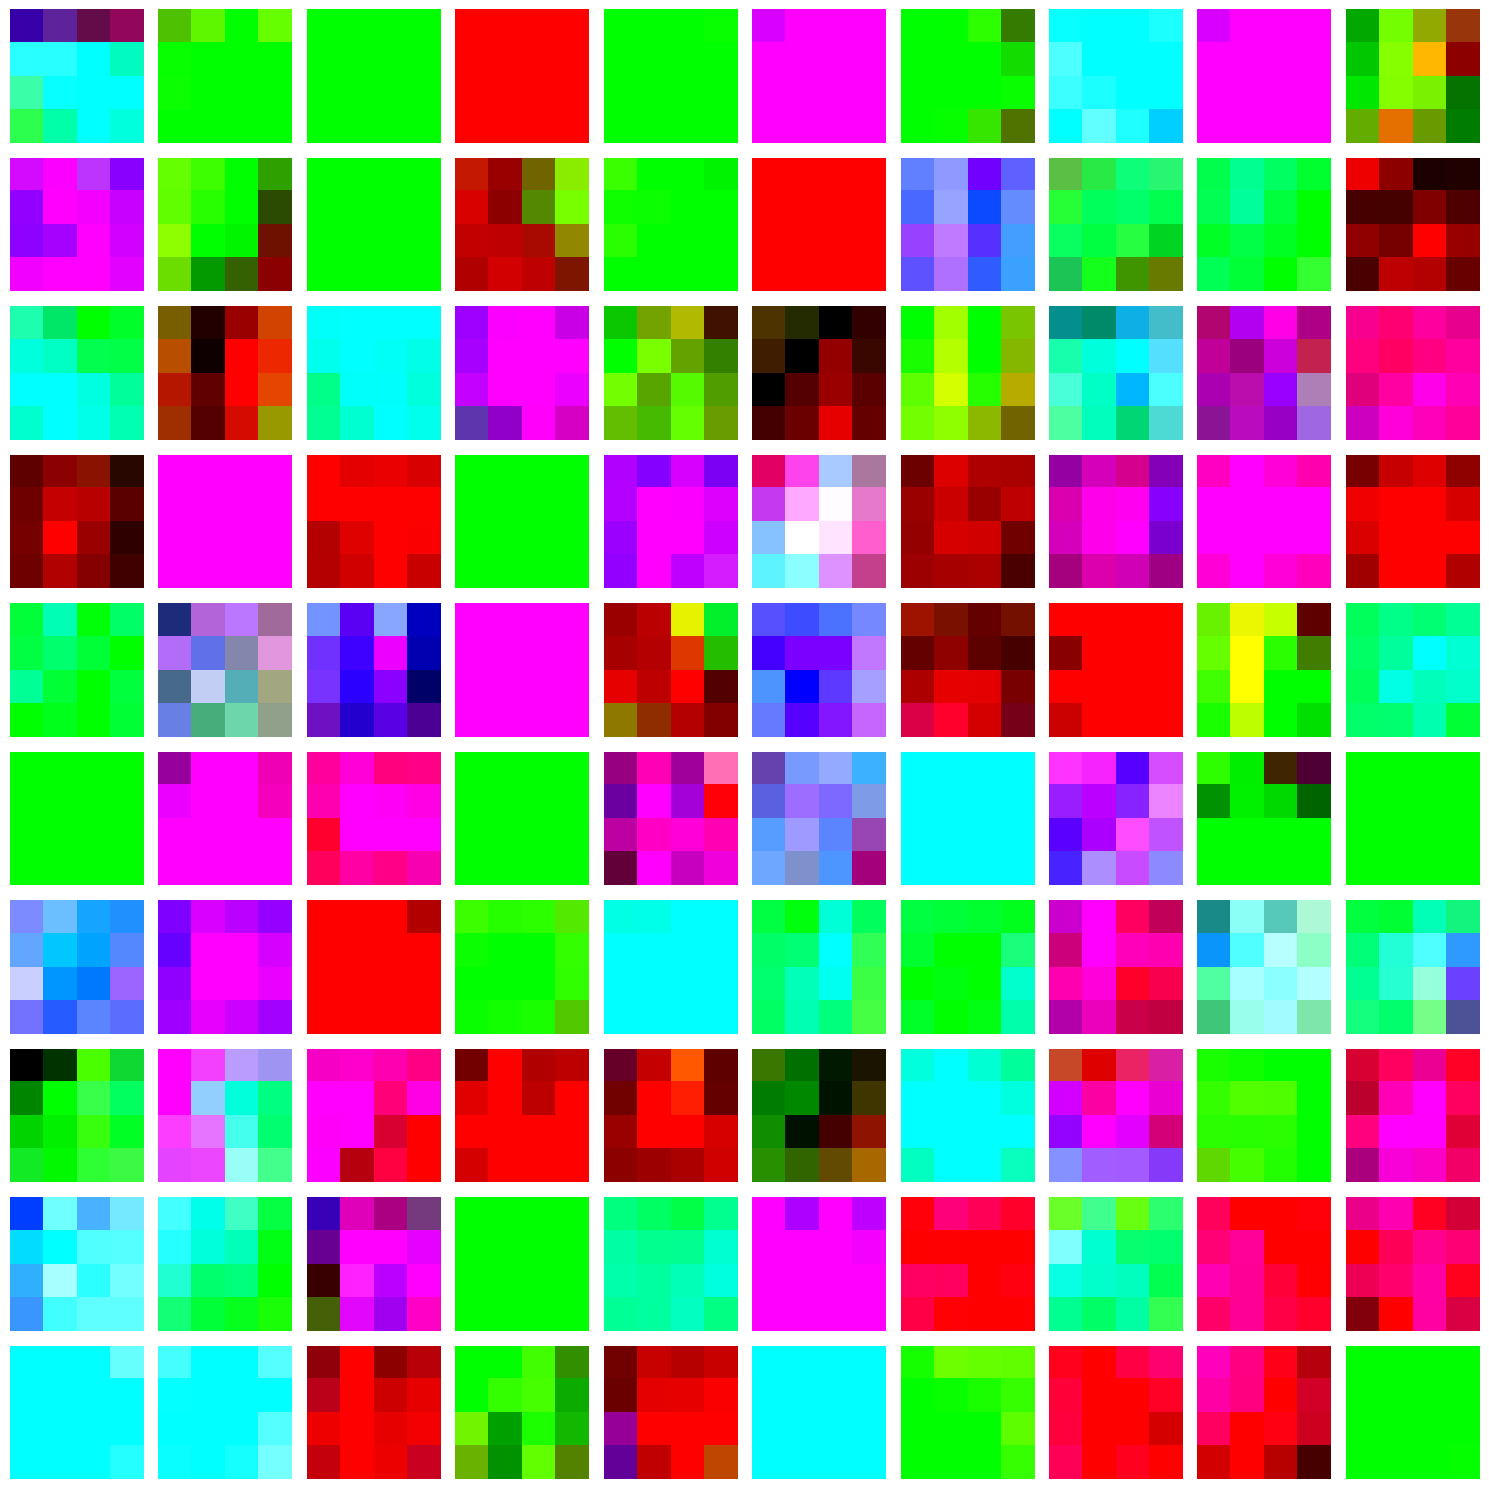

FID score at step 0: 67.38048553466797
Current image size: 8
Epoch [1/40]


100%|██████████| 40/40 [00:59<00:00,  1.49s/it, gp=0.0454, loss_critic=-3.17]


Epoch [2/40]


100%|██████████| 40/40 [00:59<00:00,  1.49s/it, gp=0.04, loss_critic=-3.23]  


Epoch [3/40]


100%|██████████| 40/40 [00:58<00:00,  1.47s/it, gp=0.0783, loss_critic=-2.84]


Epoch [4/40]


100%|██████████| 40/40 [00:59<00:00,  1.48s/it, gp=0.0447, loss_critic=-3.09]


Epoch [5/40]


100%|██████████| 40/40 [00:59<00:00,  1.49s/it, gp=0.0594, loss_critic=-2.57]


Epoch [6/40]


100%|██████████| 40/40 [00:59<00:00,  1.49s/it, gp=0.0395, loss_critic=-1.73]


Epoch [7/40]


100%|██████████| 40/40 [00:59<00:00,  1.48s/it, gp=0.0594, loss_critic=-2.94]


Epoch [8/40]


100%|██████████| 40/40 [00:59<00:00,  1.49s/it, gp=0.0532, loss_critic=-4.54]


Epoch [9/40]


100%|██████████| 40/40 [00:59<00:00,  1.49s/it, gp=0.0354, loss_critic=-3.53]


Epoch [10/40]


100%|██████████| 40/40 [00:59<00:00,  1.48s/it, gp=0.136, loss_critic=-3.44]  


Epoch [11/40]


100%|██████████| 40/40 [00:59<00:00,  1.49s/it, gp=0.0635, loss_critic=-4.08]


Epoch [12/40]


100%|██████████| 40/40 [00:59<00:00,  1.50s/it, gp=0.0309, loss_critic=-4.29]


Epoch [13/40]


100%|██████████| 40/40 [00:59<00:00,  1.49s/it, gp=0.08, loss_critic=-4.21]  


Epoch [14/40]


100%|██████████| 40/40 [00:58<00:00,  1.47s/it, gp=0.295, loss_critic=-3.92] 


Epoch [15/40]


100%|██████████| 40/40 [00:59<00:00,  1.49s/it, gp=0.0661, loss_critic=-4.55]


Epoch [16/40]


100%|██████████| 40/40 [00:58<00:00,  1.47s/it, gp=0.0684, loss_critic=-3.89]


Epoch [17/40]


100%|██████████| 40/40 [00:58<00:00,  1.47s/it, gp=0.0368, loss_critic=-3.83]


Epoch [18/40]


100%|██████████| 40/40 [00:59<00:00,  1.49s/it, gp=0.0832, loss_critic=-4.16]


Epoch [19/40]


100%|██████████| 40/40 [00:59<00:00,  1.49s/it, gp=0.0466, loss_critic=-5.31]


Epoch [20/40]


100%|██████████| 40/40 [00:58<00:00,  1.46s/it, gp=0.111, loss_critic=-4.27] 


Epoch [21/40]


100%|██████████| 40/40 [00:59<00:00,  1.48s/it, gp=0.0618, loss_critic=-4.72] 


Epoch [22/40]


100%|██████████| 40/40 [00:59<00:00,  1.50s/it, gp=0.0228, loss_critic=-3.45]


Epoch [23/40]


100%|██████████| 40/40 [00:59<00:00,  1.49s/it, gp=0.0658, loss_critic=-4.63]


Epoch [24/40]


100%|██████████| 40/40 [00:59<00:00,  1.49s/it, gp=0.0543, loss_critic=-3.86]


Epoch [25/40]


100%|██████████| 40/40 [00:59<00:00,  1.49s/it, gp=0.0246, loss_critic=-3.62]


Epoch [26/40]


100%|██████████| 40/40 [00:59<00:00,  1.48s/it, gp=0.0601, loss_critic=-3.53]


Epoch [27/40]


100%|██████████| 40/40 [00:59<00:00,  1.48s/it, gp=0.0648, loss_critic=-3.64]


Epoch [28/40]


100%|██████████| 40/40 [00:59<00:00,  1.50s/it, gp=0.0405, loss_critic=-3.77]


Epoch [29/40]


100%|██████████| 40/40 [00:58<00:00,  1.46s/it, gp=0.0446, loss_critic=-3.93]


Epoch [30/40]


100%|██████████| 40/40 [00:59<00:00,  1.48s/it, gp=0.0282, loss_critic=-2.94]


Epoch [31/40]


100%|██████████| 40/40 [00:58<00:00,  1.47s/it, gp=0.0225, loss_critic=-2.55]


Epoch [32/40]


100%|██████████| 40/40 [00:58<00:00,  1.47s/it, gp=0.0545, loss_critic=-2.66]


Epoch [33/40]


100%|██████████| 40/40 [00:59<00:00,  1.49s/it, gp=0.0435, loss_critic=-1.83]


Epoch [34/40]


100%|██████████| 40/40 [00:59<00:00,  1.50s/it, gp=0.0749, loss_critic=-2.62]


Epoch [35/40]


100%|██████████| 40/40 [00:59<00:00,  1.50s/it, gp=0.0276, loss_critic=-3.46]


Epoch [36/40]


100%|██████████| 40/40 [00:59<00:00,  1.49s/it, gp=0.0359, loss_critic=-3.47]


Epoch [37/40]


100%|██████████| 40/40 [00:59<00:00,  1.49s/it, gp=0.0115, loss_critic=-2.26]


Epoch [38/40]


100%|██████████| 40/40 [00:58<00:00,  1.47s/it, gp=0.0365, loss_critic=-2.46]


Epoch [39/40]


100%|██████████| 40/40 [00:58<00:00,  1.47s/it, gp=0.0556, loss_critic=-3.74]


Epoch [40/40]


100%|██████████| 40/40 [00:59<00:00,  1.48s/it, gp=0.0164, loss_critic=-1.63]


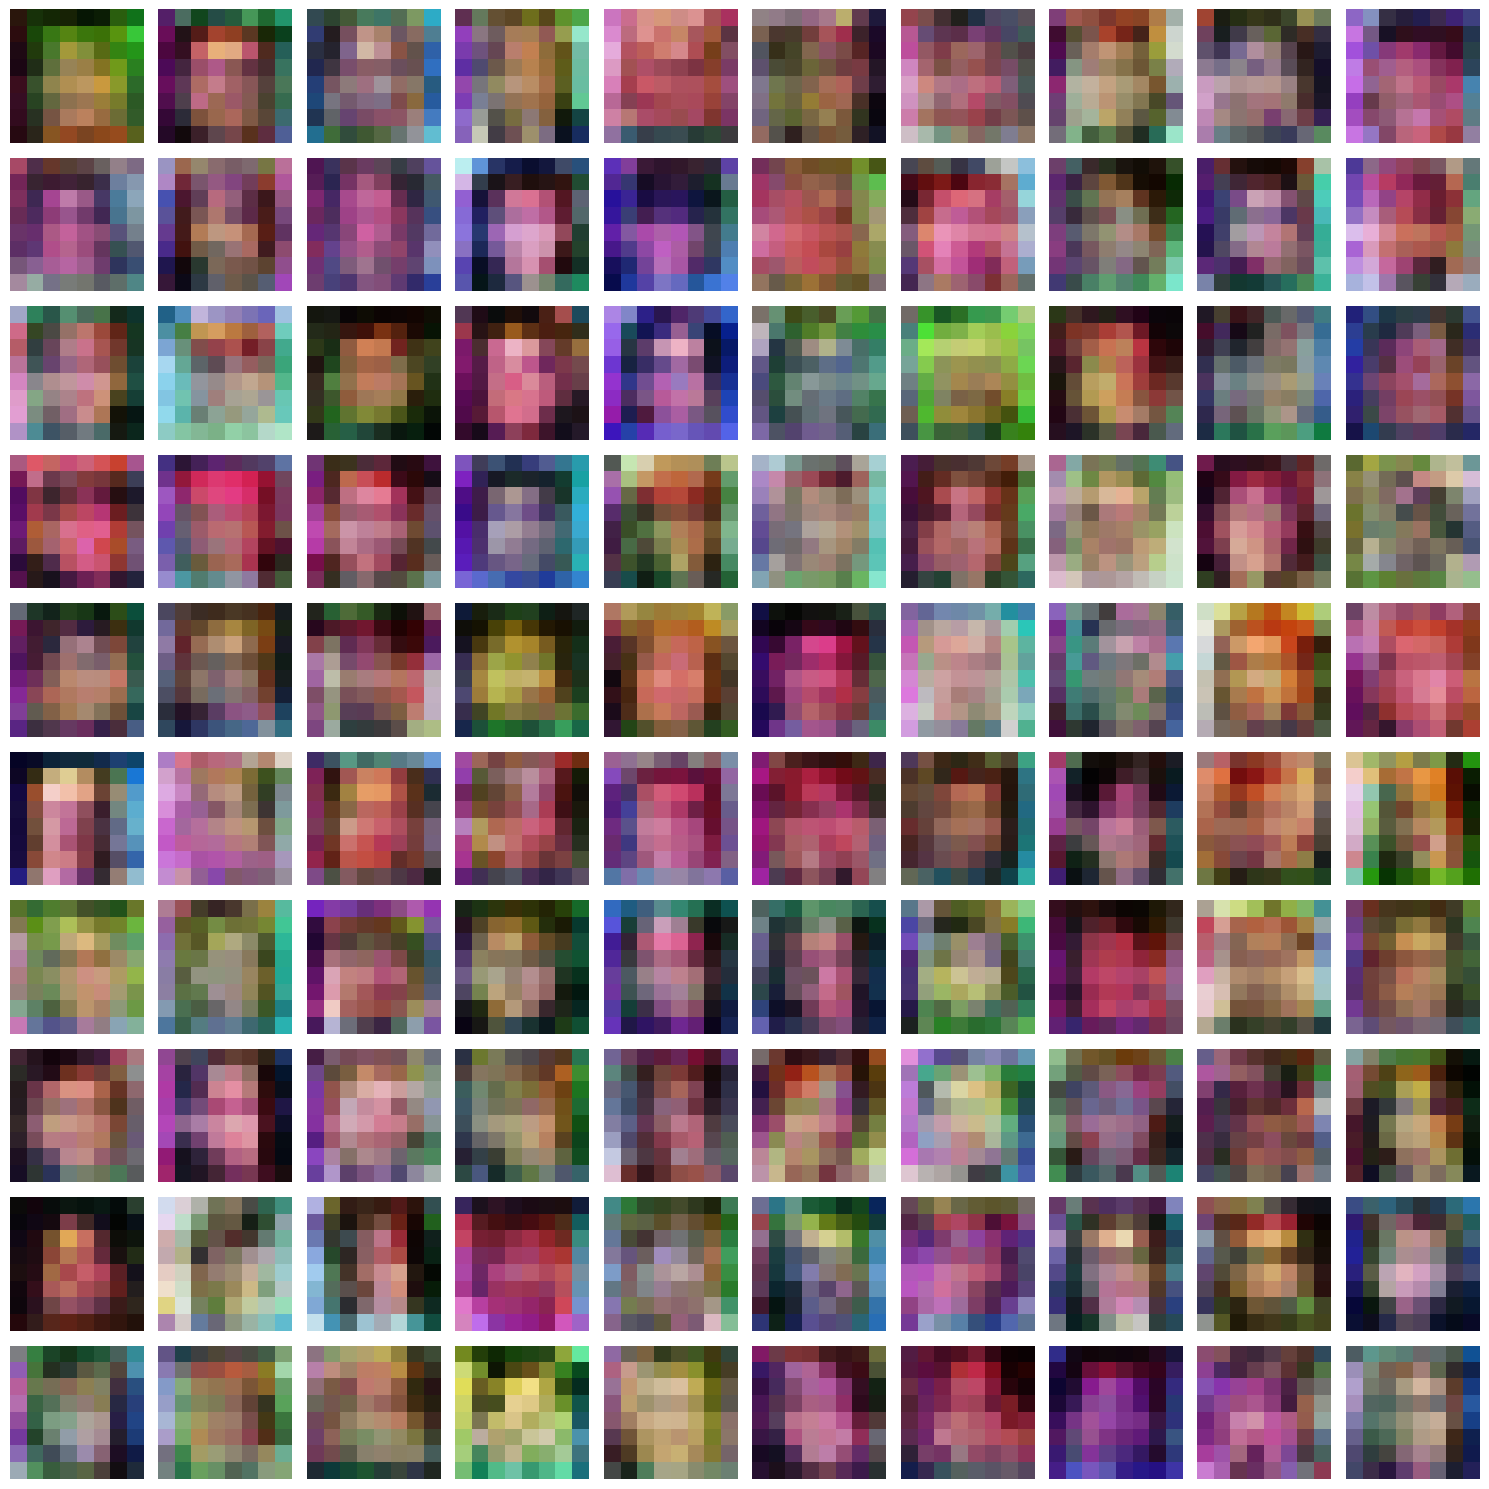

FID score at step 1: 50.43729782104492
Current image size: 16
Epoch [1/40]


100%|██████████| 79/79 [01:18<00:00,  1.00it/s, gp=0.1, loss_critic=-3.02]   


Epoch [2/40]


100%|██████████| 79/79 [01:18<00:00,  1.01it/s, gp=0.0364, loss_critic=-2.79]


Epoch [3/40]


100%|██████████| 79/79 [01:18<00:00,  1.01it/s, gp=0.0374, loss_critic=-4.25]


Epoch [4/40]


100%|██████████| 79/79 [01:18<00:00,  1.01it/s, gp=0.0118, loss_critic=-2.89]


Epoch [5/40]


100%|██████████| 79/79 [01:18<00:00,  1.01it/s, gp=0.0398, loss_critic=-3.74]


Epoch [6/40]


100%|██████████| 79/79 [01:18<00:00,  1.01it/s, gp=0.134, loss_critic=-4.83] 


Epoch [7/40]


100%|██████████| 79/79 [01:18<00:00,  1.01it/s, gp=0.0156, loss_critic=-5.04]


Epoch [8/40]


100%|██████████| 79/79 [01:17<00:00,  1.01it/s, gp=0.0314, loss_critic=-3.27]


Epoch [9/40]


100%|██████████| 79/79 [01:17<00:00,  1.01it/s, gp=0.137, loss_critic=-4]    


Epoch [10/40]


100%|██████████| 79/79 [01:18<00:00,  1.01it/s, gp=0.0899, loss_critic=-3.91]


Epoch [11/40]


100%|██████████| 79/79 [01:18<00:00,  1.01it/s, gp=0.0373, loss_critic=-3.63]


Epoch [12/40]


100%|██████████| 79/79 [01:18<00:00,  1.01it/s, gp=0.0266, loss_critic=-4.35]


Epoch [13/40]


100%|██████████| 79/79 [01:18<00:00,  1.01it/s, gp=0.0583, loss_critic=-3.62]


Epoch [14/40]


100%|██████████| 79/79 [01:18<00:00,  1.01it/s, gp=0.097, loss_critic=-6.6]  


Epoch [15/40]


100%|██████████| 79/79 [01:18<00:00,  1.01it/s, gp=0.0354, loss_critic=-3.05]


Epoch [16/40]


100%|██████████| 79/79 [01:18<00:00,  1.01it/s, gp=0.0355, loss_critic=-4.57]


Epoch [17/40]


100%|██████████| 79/79 [01:18<00:00,  1.00it/s, gp=0.0596, loss_critic=-5.78]


Epoch [18/40]


100%|██████████| 79/79 [01:18<00:00,  1.01it/s, gp=0.0658, loss_critic=-4.39]


Epoch [19/40]


100%|██████████| 79/79 [01:18<00:00,  1.01it/s, gp=0.0263, loss_critic=-4.55]


Epoch [20/40]


100%|██████████| 79/79 [01:18<00:00,  1.01it/s, gp=0.0495, loss_critic=-4.83]


Epoch [21/40]


100%|██████████| 79/79 [01:18<00:00,  1.00it/s, gp=0.0134, loss_critic=-3.85]


Epoch [22/40]


100%|██████████| 79/79 [01:18<00:00,  1.01it/s, gp=0.0645, loss_critic=-3.38]


Epoch [23/40]


100%|██████████| 79/79 [01:18<00:00,  1.01it/s, gp=0.0428, loss_critic=-3.42]


Epoch [24/40]


100%|██████████| 79/79 [01:18<00:00,  1.01it/s, gp=0.0328, loss_critic=-4.09]


Epoch [25/40]


100%|██████████| 79/79 [01:18<00:00,  1.00it/s, gp=0.0191, loss_critic=-2.9] 


Epoch [26/40]


100%|██████████| 79/79 [01:18<00:00,  1.00it/s, gp=0.0548, loss_critic=-2.78]


Epoch [27/40]


100%|██████████| 79/79 [01:18<00:00,  1.00it/s, gp=0.0376, loss_critic=-2.62]


Epoch [28/40]


100%|██████████| 79/79 [01:17<00:00,  1.02it/s, gp=0.0111, loss_critic=-3.28]


Epoch [29/40]


100%|██████████| 79/79 [01:17<00:00,  1.01it/s, gp=0.029, loss_critic=-3.55] 


Epoch [30/40]


100%|██████████| 79/79 [01:18<00:00,  1.01it/s, gp=0.0126, loss_critic=-2.54] 


Epoch [31/40]


100%|██████████| 79/79 [01:17<00:00,  1.01it/s, gp=0.0238, loss_critic=-2.15] 


Epoch [32/40]


100%|██████████| 79/79 [01:17<00:00,  1.01it/s, gp=0.0195, loss_critic=-2.36]


Epoch [33/40]


100%|██████████| 79/79 [01:17<00:00,  1.01it/s, gp=0.0177, loss_critic=-2.39] 


Epoch [34/40]


100%|██████████| 79/79 [01:18<00:00,  1.01it/s, gp=0.0266, loss_critic=-2.41] 


Epoch [35/40]


100%|██████████| 79/79 [01:18<00:00,  1.01it/s, gp=0.0233, loss_critic=-1.92] 


Epoch [36/40]


100%|██████████| 79/79 [01:18<00:00,  1.01it/s, gp=0.0124, loss_critic=-2.2]  


Epoch [37/40]


100%|██████████| 79/79 [01:18<00:00,  1.01it/s, gp=0.0145, loss_critic=-2.2]  


Epoch [38/40]


100%|██████████| 79/79 [01:18<00:00,  1.01it/s, gp=0.0145, loss_critic=-.704] 


Epoch [39/40]


100%|██████████| 79/79 [01:18<00:00,  1.00it/s, gp=0.0115, loss_critic=-1.7]  


Epoch [40/40]


100%|██████████| 79/79 [01:18<00:00,  1.01it/s, gp=0.00482, loss_critic=-2.31]


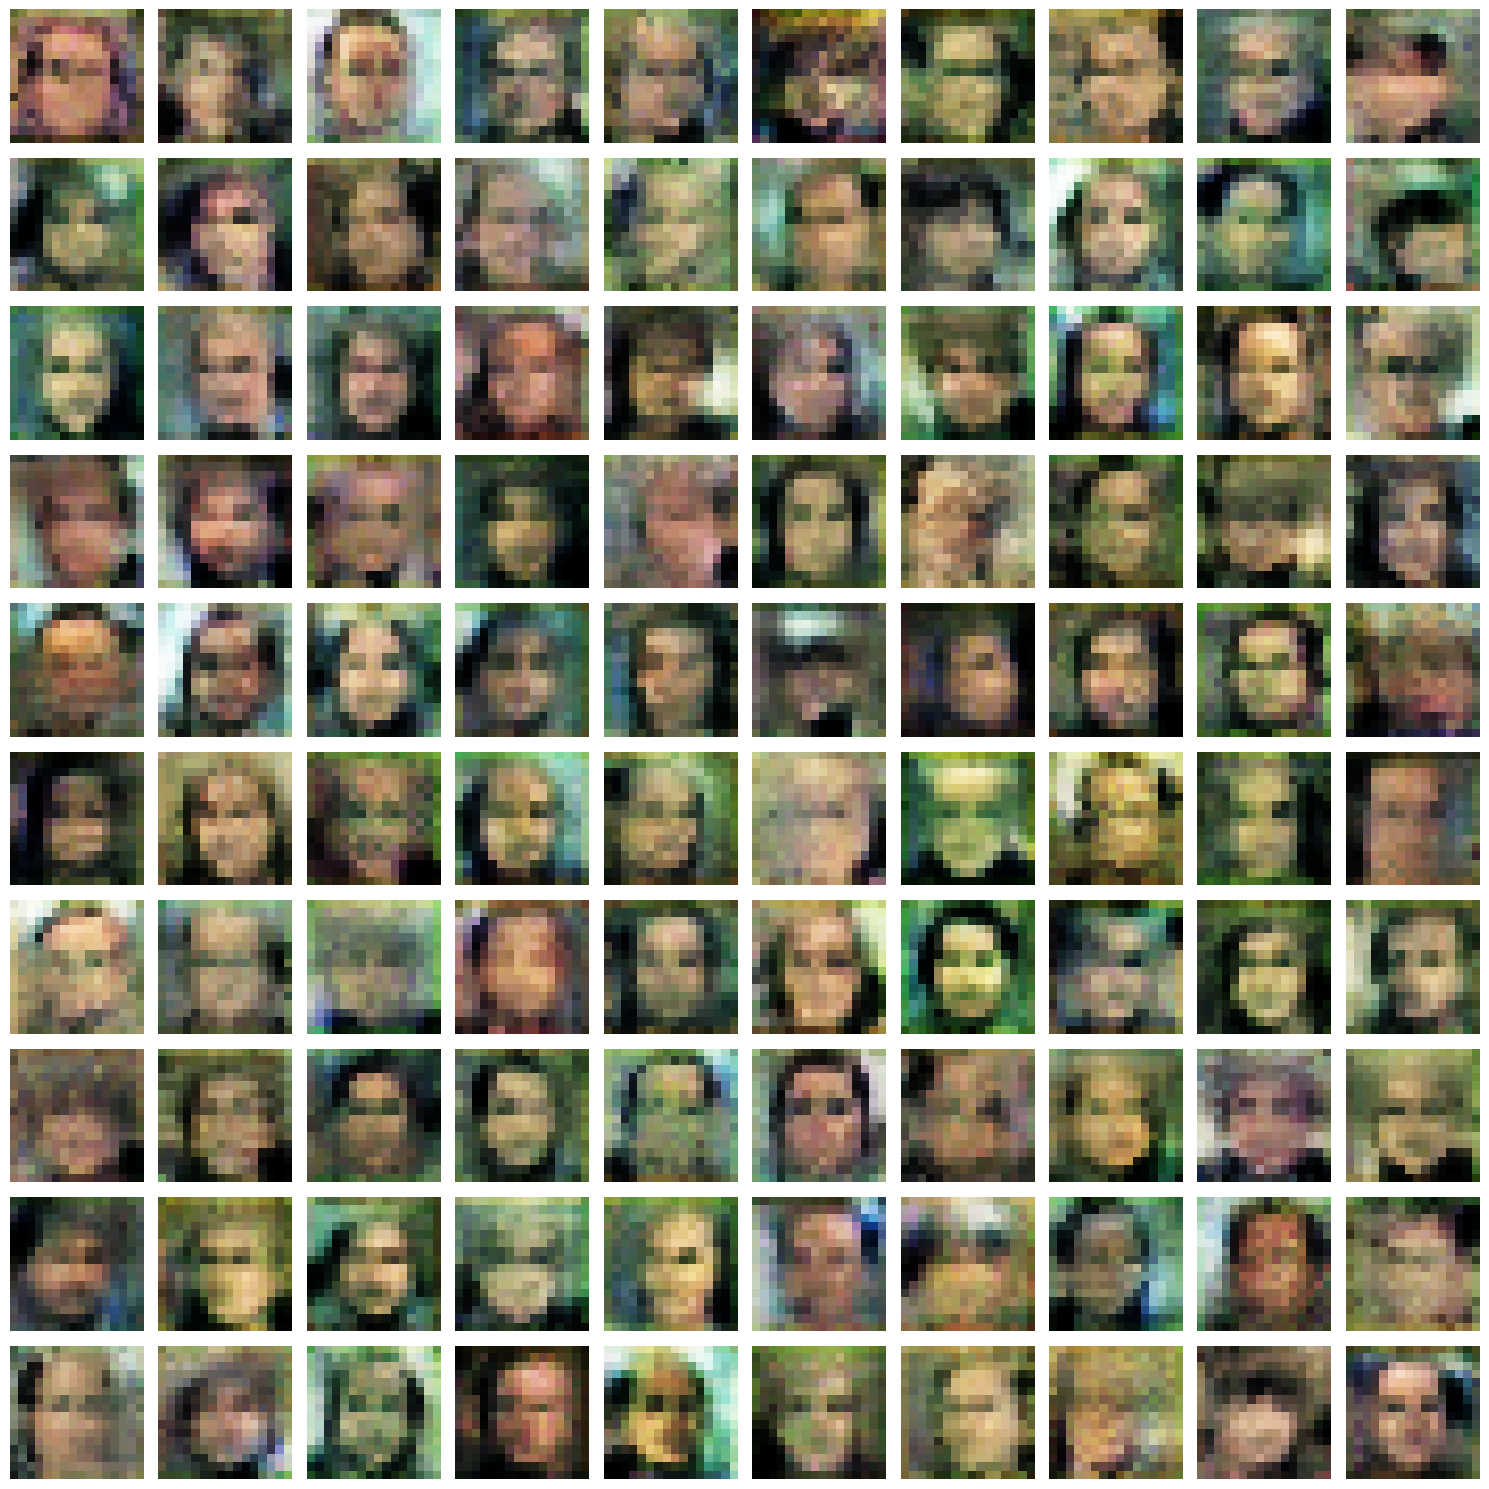

FID score at step 2: 55.1697883605957
Current image size: 32
Epoch [1/40]


100%|██████████| 157/157 [02:07<00:00,  1.23it/s, gp=0.0199, loss_critic=-3.73]


Epoch [2/40]


100%|██████████| 157/157 [02:07<00:00,  1.23it/s, gp=0.115, loss_critic=-4.1]   


Epoch [3/40]


100%|██████████| 157/157 [02:07<00:00,  1.23it/s, gp=0.119, loss_critic=-4.66] 


Epoch [4/40]


100%|██████████| 157/157 [02:07<00:00,  1.23it/s, gp=0.0332, loss_critic=-2.57]


Epoch [5/40]


100%|██████████| 157/157 [02:07<00:00,  1.23it/s, gp=0.021, loss_critic=-5]     


Epoch [6/40]


100%|██████████| 157/157 [02:07<00:00,  1.23it/s, gp=0.00863, loss_critic=-4.19]


Epoch [7/40]


100%|██████████| 157/157 [02:07<00:00,  1.23it/s, gp=0.284, loss_critic=-2.48]  


Epoch [8/40]


100%|██████████| 157/157 [02:07<00:00,  1.23it/s, gp=0.015, loss_critic=-3.49] 


Epoch [9/40]


100%|██████████| 157/157 [02:07<00:00,  1.23it/s, gp=0.0236, loss_critic=-2.07]


Epoch [10/40]


100%|██████████| 157/157 [02:07<00:00,  1.23it/s, gp=0.0573, loss_critic=-2.84] 


Epoch [11/40]


100%|██████████| 157/157 [02:07<00:00,  1.23it/s, gp=0.139, loss_critic=-3.04]  


Epoch [12/40]


100%|██████████| 157/157 [02:07<00:00,  1.23it/s, gp=0.0267, loss_critic=-2.67] 


Epoch [13/40]


100%|██████████| 157/157 [02:07<00:00,  1.23it/s, gp=0.0906, loss_critic=-3.21]


Epoch [14/40]


100%|██████████| 157/157 [02:08<00:00,  1.23it/s, gp=0.0168, loss_critic=-3.94] 


Epoch [15/40]


100%|██████████| 157/157 [02:08<00:00,  1.23it/s, gp=0.0402, loss_critic=-2.29] 


Epoch [16/40]


100%|██████████| 157/157 [02:07<00:00,  1.23it/s, gp=0.0484, loss_critic=-2.92] 


Epoch [17/40]


100%|██████████| 157/157 [02:07<00:00,  1.23it/s, gp=0.0151, loss_critic=-3.39]


Epoch [18/40]


100%|██████████| 157/157 [02:08<00:00,  1.23it/s, gp=0.00868, loss_critic=-2.03]


Epoch [19/40]


100%|██████████| 157/157 [02:07<00:00,  1.23it/s, gp=0.015, loss_critic=-2.35] 


Epoch [20/40]


100%|██████████| 157/157 [02:08<00:00,  1.23it/s, gp=0.0155, loss_critic=-2.39]


Epoch [21/40]


100%|██████████| 157/157 [02:06<00:00,  1.24it/s, gp=0.0206, loss_critic=-1.89] 


Epoch [22/40]


100%|██████████| 157/157 [02:07<00:00,  1.23it/s, gp=0.0125, loss_critic=-2.13] 


Epoch [23/40]


100%|██████████| 157/157 [02:06<00:00,  1.24it/s, gp=0.0241, loss_critic=-2]    


Epoch [24/40]


100%|██████████| 157/157 [02:06<00:00,  1.24it/s, gp=0.0938, loss_critic=-1.93] 


Epoch [25/40]


100%|██████████| 157/157 [02:06<00:00,  1.24it/s, gp=0.0191, loss_critic=-1.72] 


Epoch [26/40]


100%|██████████| 157/157 [02:06<00:00,  1.24it/s, gp=0.0115, loss_critic=-1.79] 


Epoch [27/40]


100%|██████████| 157/157 [02:05<00:00,  1.25it/s, gp=0.00506, loss_critic=-1.92]


Epoch [28/40]


100%|██████████| 157/157 [02:06<00:00,  1.24it/s, gp=0.0172, loss_critic=-2.98] 


Epoch [29/40]


100%|██████████| 157/157 [02:07<00:00,  1.24it/s, gp=0.0383, loss_critic=-3.29] 


Epoch [30/40]


100%|██████████| 157/157 [02:06<00:00,  1.24it/s, gp=0.051, loss_critic=-1.17]  


Epoch [31/40]


100%|██████████| 157/157 [02:06<00:00,  1.24it/s, gp=0.00392, loss_critic=-1.49]


Epoch [32/40]


100%|██████████| 157/157 [02:07<00:00,  1.23it/s, gp=0.0241, loss_critic=-2.3]  


Epoch [33/40]


100%|██████████| 157/157 [02:07<00:00,  1.24it/s, gp=0.00758, loss_critic=-1.74]


Epoch [34/40]


100%|██████████| 157/157 [02:07<00:00,  1.23it/s, gp=0.04, loss_critic=-1.1]    


Epoch [35/40]


100%|██████████| 157/157 [02:06<00:00,  1.24it/s, gp=0.00534, loss_critic=-1.13]


Epoch [36/40]


100%|██████████| 157/157 [02:08<00:00,  1.23it/s, gp=0.0398, loss_critic=-1.39] 


Epoch [37/40]


100%|██████████| 157/157 [02:07<00:00,  1.23it/s, gp=0.0182, loss_critic=-1.61] 


Epoch [38/40]


100%|██████████| 157/157 [02:07<00:00,  1.23it/s, gp=0.014, loss_critic=-1.9]   


Epoch [39/40]


100%|██████████| 157/157 [02:06<00:00,  1.24it/s, gp=0.0449, loss_critic=-1.01] 


Epoch [40/40]


100%|██████████| 157/157 [02:07<00:00,  1.23it/s, gp=0.0124, loss_critic=-1.21] 


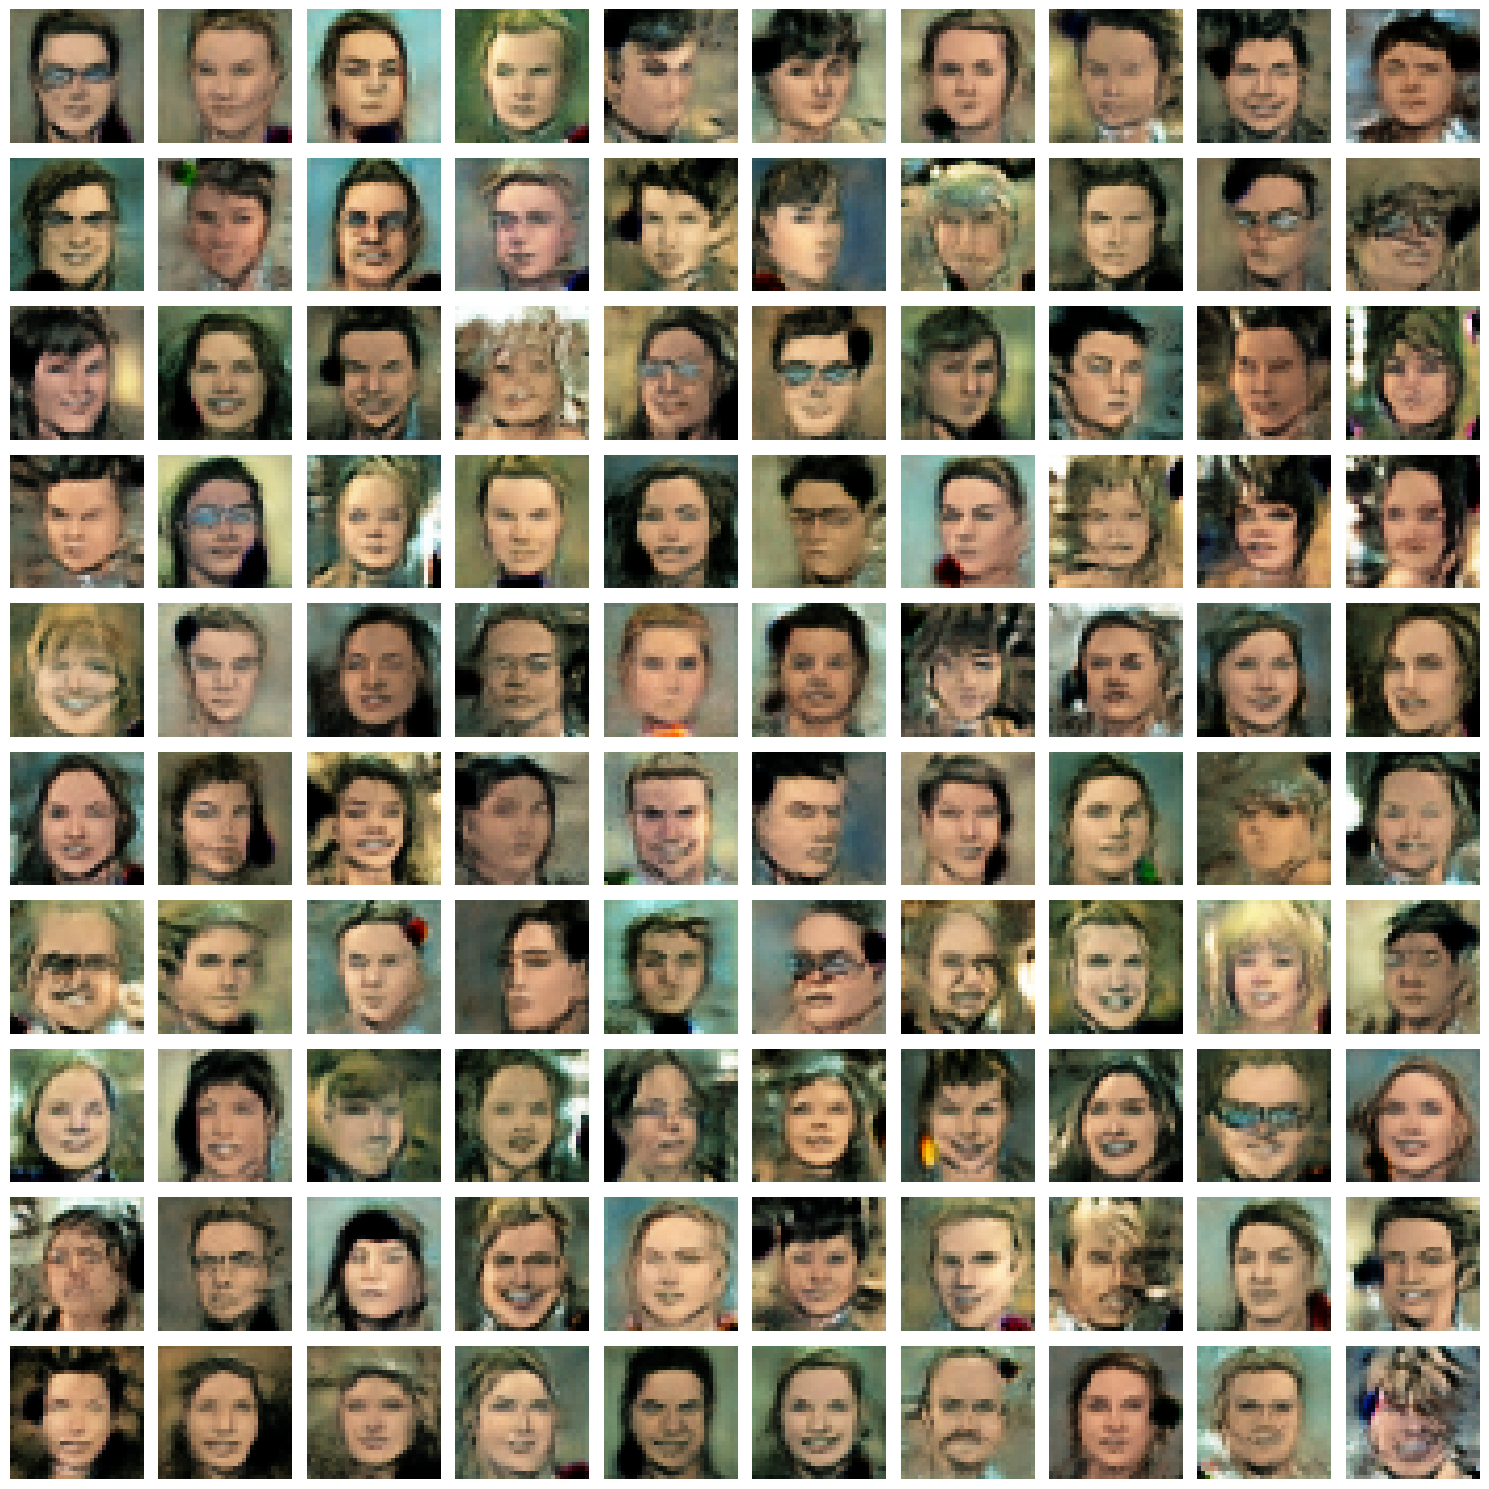

FID score at step 3: 51.26017379760742
Current image size: 64
Epoch [1/40]


100%|██████████| 313/313 [03:29<00:00,  1.50it/s, gp=0.00626, loss_critic=-3.08]


Epoch [2/40]


100%|██████████| 313/313 [03:29<00:00,  1.50it/s, gp=0.0117, loss_critic=-1.61] 


Epoch [3/40]


100%|██████████| 313/313 [03:29<00:00,  1.50it/s, gp=0.0278, loss_critic=-4.64] 


Epoch [4/40]


100%|██████████| 313/313 [03:28<00:00,  1.50it/s, gp=0.0314, loss_critic=-4.09]


Epoch [5/40]


100%|██████████| 313/313 [03:29<00:00,  1.50it/s, gp=0.0494, loss_critic=-4.58]


Epoch [6/40]


100%|██████████| 313/313 [03:28<00:00,  1.50it/s, gp=0.0759, loss_critic=-2.42]


Epoch [7/40]


100%|██████████| 313/313 [03:28<00:00,  1.50it/s, gp=0.04, loss_critic=-4.46]  


Epoch [8/40]


100%|██████████| 313/313 [03:28<00:00,  1.50it/s, gp=0.0231, loss_critic=-4.05]


Epoch [9/40]


100%|██████████| 313/313 [03:29<00:00,  1.49it/s, gp=0.0281, loss_critic=-2.82]


Epoch [10/40]


100%|██████████| 313/313 [03:29<00:00,  1.50it/s, gp=0.0507, loss_critic=-2.38]


Epoch [11/40]


100%|██████████| 313/313 [03:28<00:00,  1.50it/s, gp=0.0249, loss_critic=-4.19]


Epoch [12/40]


100%|██████████| 313/313 [03:29<00:00,  1.50it/s, gp=0.0707, loss_critic=-2.62]


Epoch [13/40]


100%|██████████| 313/313 [03:29<00:00,  1.50it/s, gp=0.0486, loss_critic=-3.07]


Epoch [14/40]


100%|██████████| 313/313 [03:29<00:00,  1.50it/s, gp=0.0371, loss_critic=-5.35]


Epoch [15/40]


100%|██████████| 313/313 [03:29<00:00,  1.50it/s, gp=0.058, loss_critic=-2.27]  


Epoch [16/40]


100%|██████████| 313/313 [03:29<00:00,  1.50it/s, gp=0.0437, loss_critic=-3.42]


Epoch [17/40]


100%|██████████| 313/313 [03:29<00:00,  1.49it/s, gp=0.0676, loss_critic=-3.26]


Epoch [18/40]


100%|██████████| 313/313 [03:29<00:00,  1.50it/s, gp=0.0715, loss_critic=-2.7] 


Epoch [19/40]


100%|██████████| 313/313 [03:29<00:00,  1.49it/s, gp=0.0419, loss_critic=-3.11]


Epoch [20/40]


100%|██████████| 313/313 [03:29<00:00,  1.49it/s, gp=0.0516, loss_critic=-2.4] 


Epoch [21/40]


100%|██████████| 313/313 [03:29<00:00,  1.50it/s, gp=0.0339, loss_critic=-2.04]


Epoch [22/40]


100%|██████████| 313/313 [03:29<00:00,  1.50it/s, gp=0.037, loss_critic=-5.86] 


Epoch [23/40]


100%|██████████| 313/313 [03:28<00:00,  1.50it/s, gp=0.0268, loss_critic=-4.98]


Epoch [24/40]


100%|██████████| 313/313 [03:29<00:00,  1.50it/s, gp=0.0447, loss_critic=-6.08]


Epoch [25/40]


100%|██████████| 313/313 [03:28<00:00,  1.50it/s, gp=0.0696, loss_critic=-2.36] 


Epoch [26/40]


100%|██████████| 313/313 [03:29<00:00,  1.50it/s, gp=0.0543, loss_critic=-1.77]


Epoch [27/40]


100%|██████████| 313/313 [03:29<00:00,  1.49it/s, gp=0.0384, loss_critic=-4.29] 


Epoch [28/40]


100%|██████████| 313/313 [03:29<00:00,  1.49it/s, gp=0.0333, loss_critic=-2.39]


Epoch [29/40]


100%|██████████| 313/313 [03:29<00:00,  1.49it/s, gp=0.03, loss_critic=-2.2]   


Epoch [30/40]


100%|██████████| 313/313 [03:29<00:00,  1.50it/s, gp=0.0482, loss_critic=-3.09] 


Epoch [31/40]


100%|██████████| 313/313 [03:29<00:00,  1.50it/s, gp=0.0432, loss_critic=-2.12] 


Epoch [32/40]


100%|██████████| 313/313 [03:29<00:00,  1.50it/s, gp=0.0317, loss_critic=-2.73]


Epoch [33/40]


100%|██████████| 313/313 [03:29<00:00,  1.49it/s, gp=0.0237, loss_critic=-2.41] 


Epoch [34/40]


100%|██████████| 313/313 [03:29<00:00,  1.50it/s, gp=0.0315, loss_critic=-4.94]


Epoch [35/40]


100%|██████████| 313/313 [03:29<00:00,  1.49it/s, gp=0.0274, loss_critic=-2.26] 


Epoch [36/40]


100%|██████████| 313/313 [03:29<00:00,  1.50it/s, gp=0.0195, loss_critic=-1.2]  


Epoch [37/40]


100%|██████████| 313/313 [03:29<00:00,  1.49it/s, gp=0.0385, loss_critic=-5.33] 


Epoch [38/40]


100%|██████████| 313/313 [03:28<00:00,  1.50it/s, gp=0.0345, loss_critic=-3.06] 


Epoch [39/40]


100%|██████████| 313/313 [03:28<00:00,  1.50it/s, gp=0.0287, loss_critic=-1.48]


Epoch [40/40]


100%|██████████| 313/313 [03:29<00:00,  1.50it/s, gp=0.0389, loss_critic=-3.16]


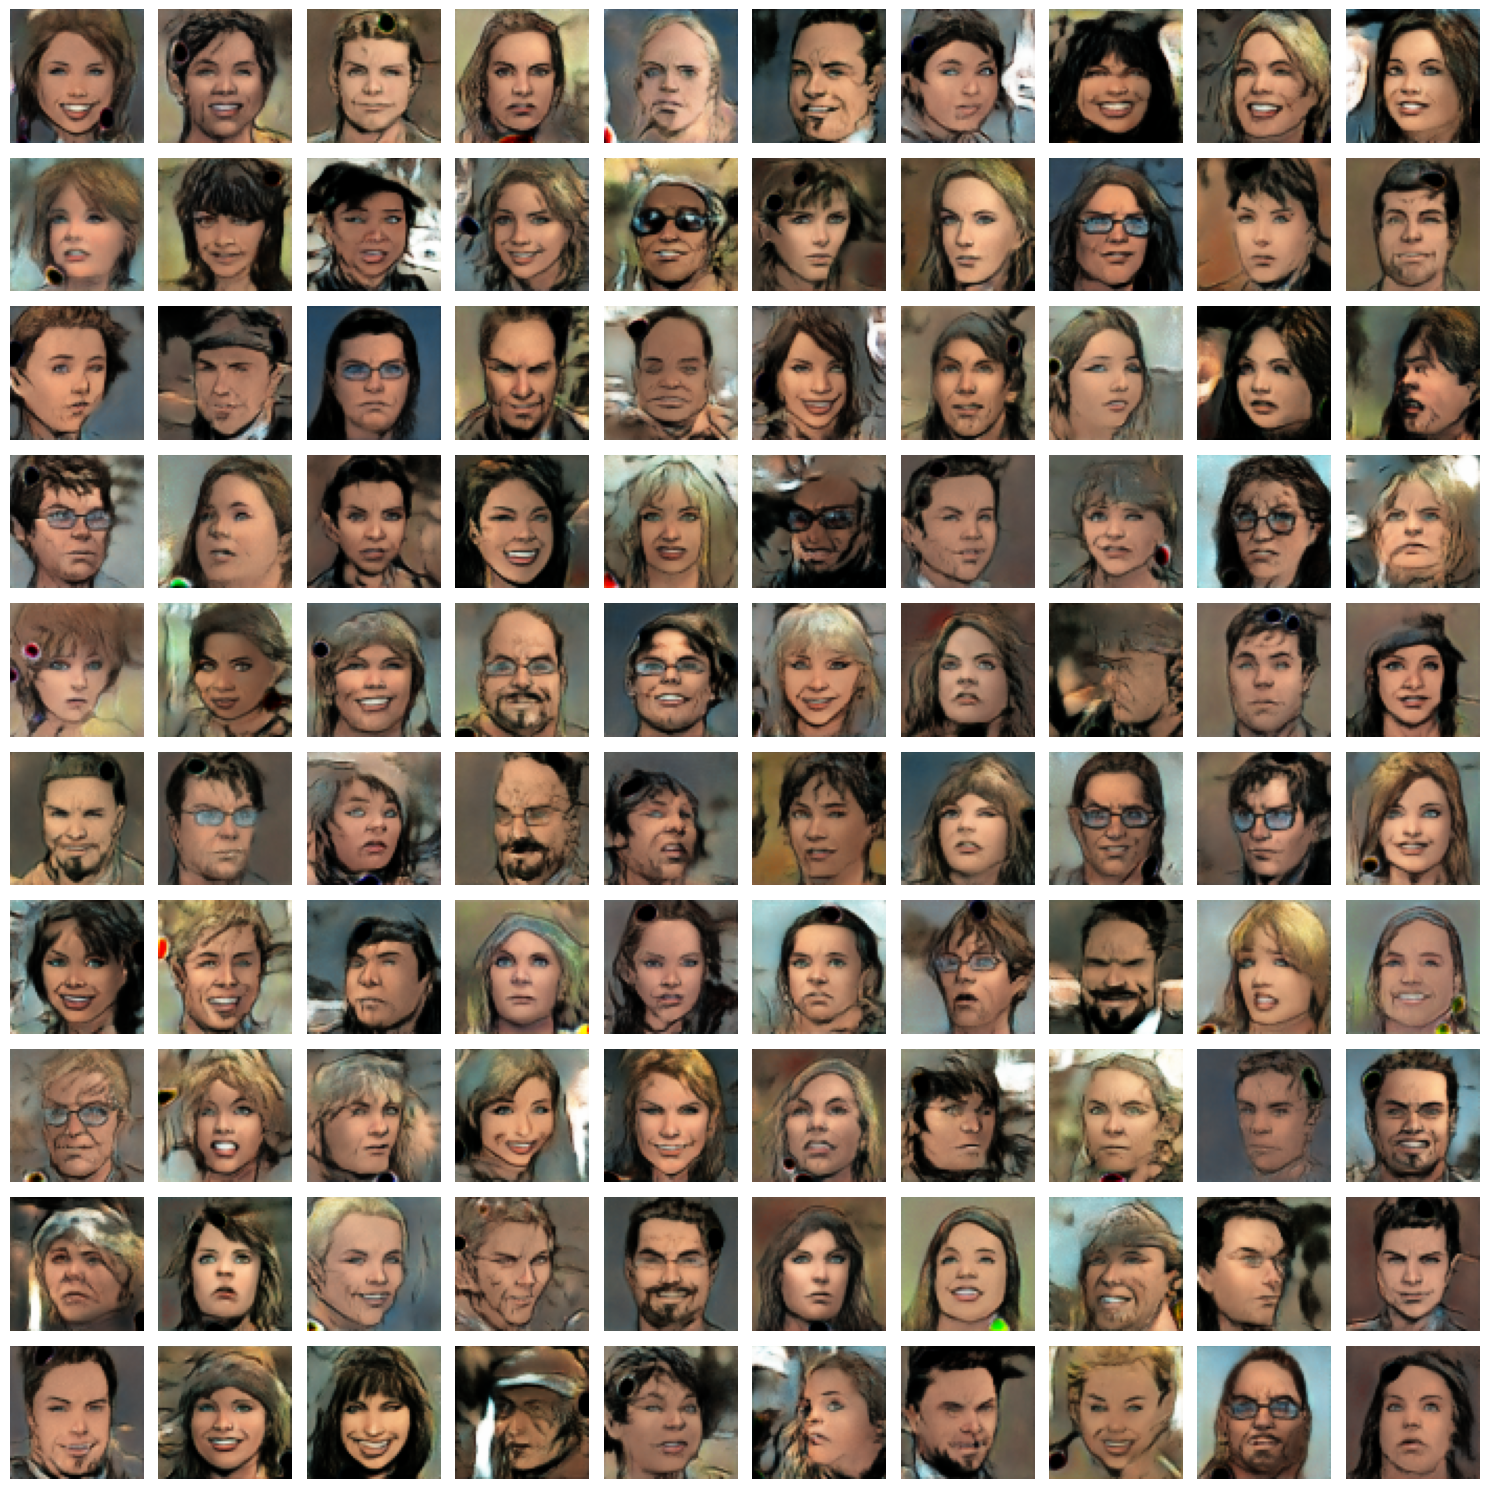

FID score at step 4: 35.43425369262695
Current image size: 128
Epoch [1/40]


100%|██████████| 625/625 [06:07<00:00,  1.70it/s, gp=0.192, loss_critic=-13.9] 


Epoch [2/40]


100%|██████████| 625/625 [06:06<00:00,  1.70it/s, gp=0.307, loss_critic=-4.33] 


Epoch [3/40]


100%|██████████| 625/625 [06:07<00:00,  1.70it/s, gp=0.137, loss_critic=-7.24] 


Epoch [4/40]


100%|██████████| 625/625 [06:06<00:00,  1.70it/s, gp=0.132, loss_critic=-11.9] 


Epoch [5/40]


100%|██████████| 625/625 [06:07<00:00,  1.70it/s, gp=0.274, loss_critic=-8.29] 


Epoch [6/40]


100%|██████████| 625/625 [06:06<00:00,  1.70it/s, gp=0.104, loss_critic=-13]   


Epoch [7/40]


100%|██████████| 625/625 [06:06<00:00,  1.71it/s, gp=0.0824, loss_critic=-8.08]


Epoch [8/40]


100%|██████████| 625/625 [06:07<00:00,  1.70it/s, gp=0.125, loss_critic=-10.7] 


Epoch [9/40]


100%|██████████| 625/625 [06:06<00:00,  1.70it/s, gp=0.101, loss_critic=-6.76] 


Epoch [10/40]


100%|██████████| 625/625 [06:07<00:00,  1.70it/s, gp=0.122, loss_critic=-10.6] 


Epoch [11/40]


100%|██████████| 625/625 [06:06<00:00,  1.70it/s, gp=0.146, loss_critic=-2.24] 


Epoch [12/40]


100%|██████████| 625/625 [06:06<00:00,  1.71it/s, gp=0.0854, loss_critic=-6.39]


Epoch [13/40]


100%|██████████| 625/625 [06:06<00:00,  1.71it/s, gp=0.16, loss_critic=-6.23]  


Epoch [14/40]


100%|██████████| 625/625 [06:06<00:00,  1.71it/s, gp=0.113, loss_critic=-8.05]  


Epoch [15/40]


100%|██████████| 625/625 [06:07<00:00,  1.70it/s, gp=0.123, loss_critic=-7.53] 


Epoch [16/40]


100%|██████████| 625/625 [06:06<00:00,  1.71it/s, gp=0.0813, loss_critic=-9.53]


Epoch [17/40]


100%|██████████| 625/625 [06:06<00:00,  1.71it/s, gp=0.0813, loss_critic=-7.48]


Epoch [18/40]


100%|██████████| 625/625 [06:07<00:00,  1.70it/s, gp=0.108, loss_critic=-6.78] 


Epoch [19/40]


100%|██████████| 625/625 [06:04<00:00,  1.71it/s, gp=0.134, loss_critic=-6.93] 


Epoch [20/40]


100%|██████████| 625/625 [06:07<00:00,  1.70it/s, gp=0.102, loss_critic=-4.69] 


Epoch [21/40]


100%|██████████| 625/625 [06:06<00:00,  1.70it/s, gp=0.259, loss_critic=-3.44] 


Epoch [22/40]


100%|██████████| 625/625 [06:05<00:00,  1.71it/s, gp=0.0692, loss_critic=-4.4] 


Epoch [23/40]


100%|██████████| 625/625 [06:06<00:00,  1.71it/s, gp=0.0978, loss_critic=-12.4]


Epoch [24/40]


100%|██████████| 625/625 [06:07<00:00,  1.70it/s, gp=0.0778, loss_critic=-8.27]


Epoch [25/40]


100%|██████████| 625/625 [06:06<00:00,  1.71it/s, gp=0.0908, loss_critic=-3.09]


Epoch [26/40]


100%|██████████| 625/625 [06:06<00:00,  1.71it/s, gp=0.1, loss_critic=-9.95]   


Epoch [27/40]


100%|██████████| 625/625 [06:06<00:00,  1.71it/s, gp=0.0612, loss_critic=-4.25]


Epoch [28/40]


100%|██████████| 625/625 [06:06<00:00,  1.71it/s, gp=0.0826, loss_critic=-3.89]


Epoch [29/40]


100%|██████████| 625/625 [06:07<00:00,  1.70it/s, gp=0.106, loss_critic=-6.37] 


Epoch [30/40]


100%|██████████| 625/625 [06:06<00:00,  1.71it/s, gp=0.0559, loss_critic=-6.21]


Epoch [31/40]


100%|██████████| 625/625 [06:07<00:00,  1.70it/s, gp=0.14, loss_critic=-5.73]  


Epoch [32/40]


100%|██████████| 625/625 [06:06<00:00,  1.70it/s, gp=0.0671, loss_critic=-4.5] 


Epoch [33/40]


100%|██████████| 625/625 [06:06<00:00,  1.71it/s, gp=0.101, loss_critic=-7.48] 


Epoch [34/40]


100%|██████████| 625/625 [06:07<00:00,  1.70it/s, gp=0.0552, loss_critic=-6.2] 


Epoch [35/40]


100%|██████████| 625/625 [06:05<00:00,  1.71it/s, gp=0.102, loss_critic=-1.22] 


Epoch [36/40]


100%|██████████| 625/625 [06:06<00:00,  1.71it/s, gp=0.0641, loss_critic=2.39] 


Epoch [37/40]


100%|██████████| 625/625 [06:06<00:00,  1.71it/s, gp=0.0744, loss_critic=-4.96]


Epoch [38/40]


100%|██████████| 625/625 [06:06<00:00,  1.70it/s, gp=0.0644, loss_critic=-6.57]


Epoch [39/40]


100%|██████████| 625/625 [06:08<00:00,  1.70it/s, gp=0.0713, loss_critic=-5.49]


Epoch [40/40]


100%|██████████| 625/625 [06:06<00:00,  1.70it/s, gp=0.086, loss_critic=-12.3] 


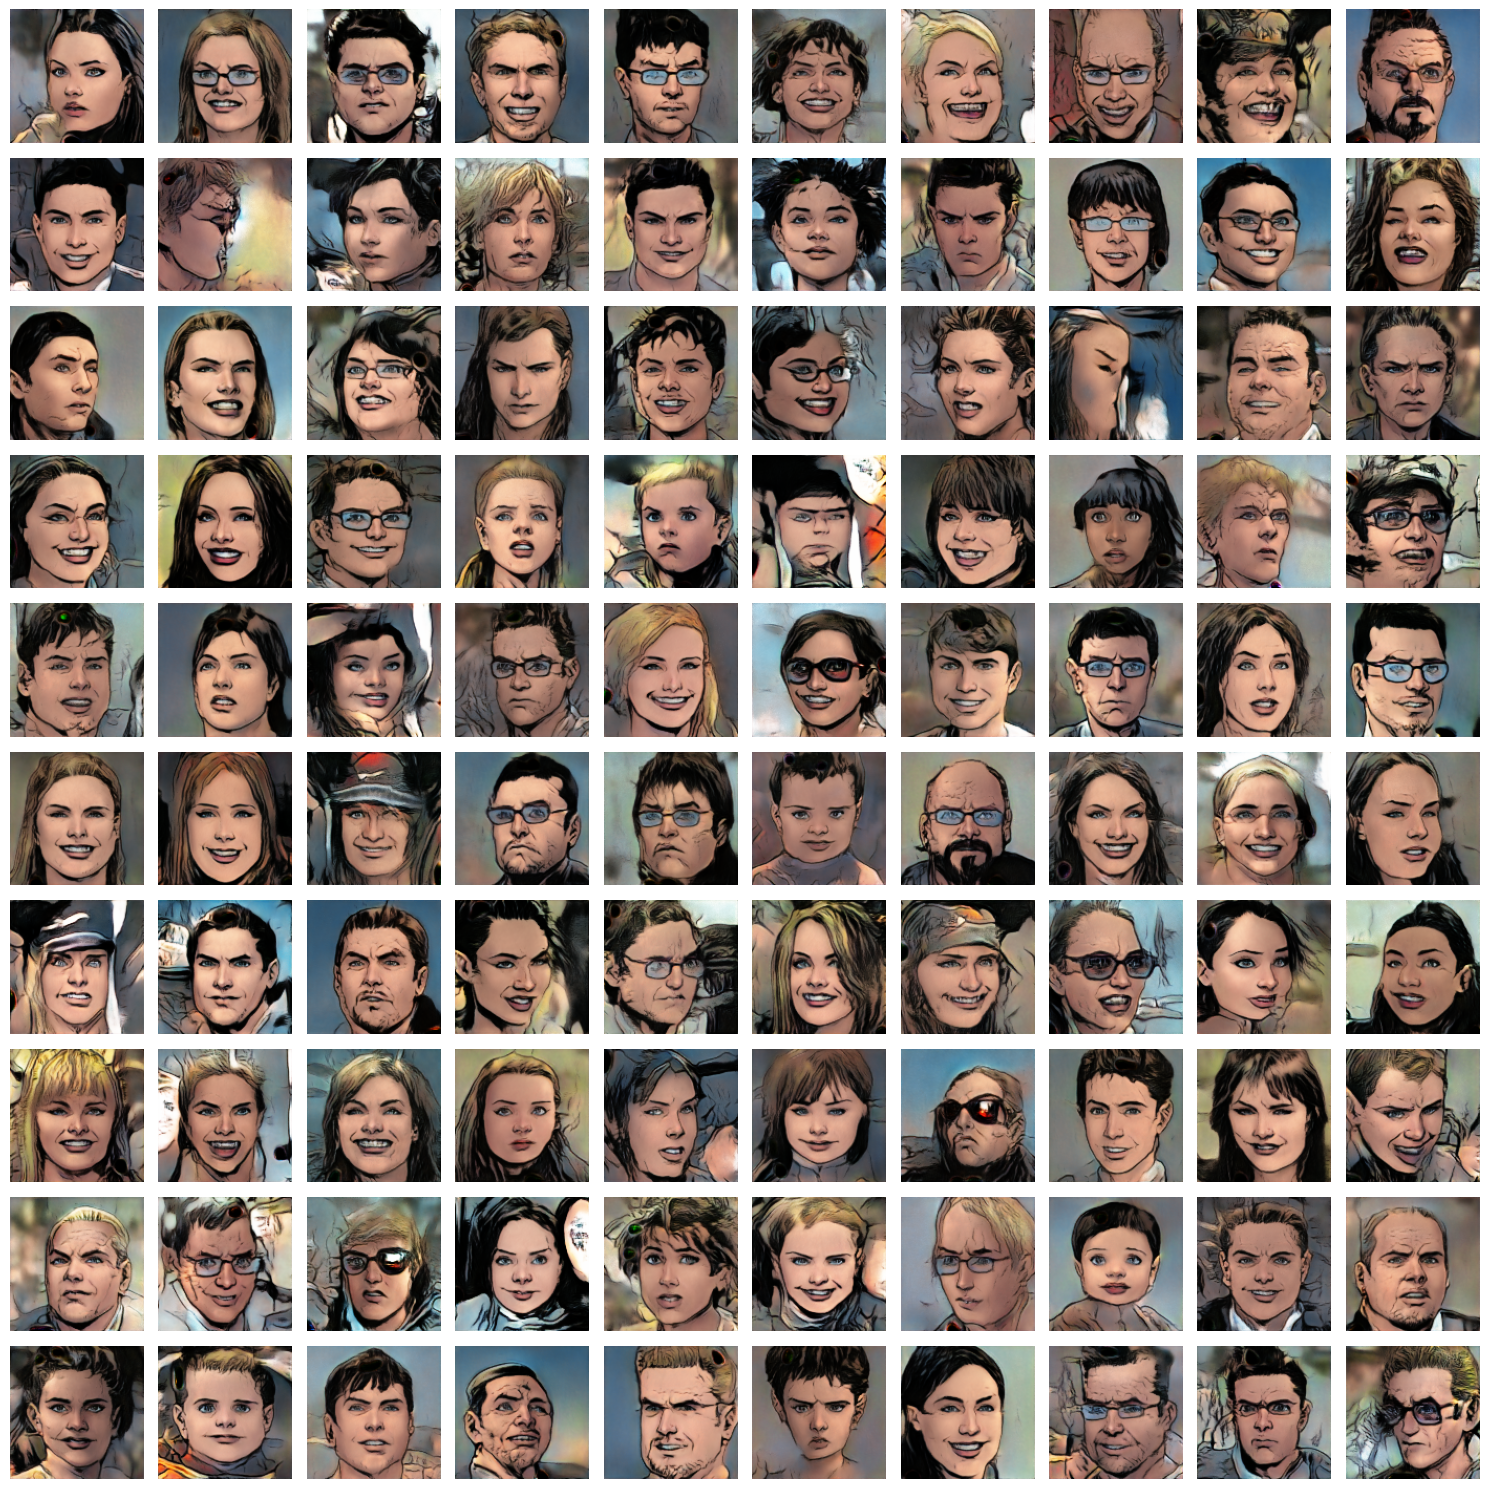

FID score at step 5: 15.576030731201172
FID scores saved to fid_scores.csv.
Models saved!


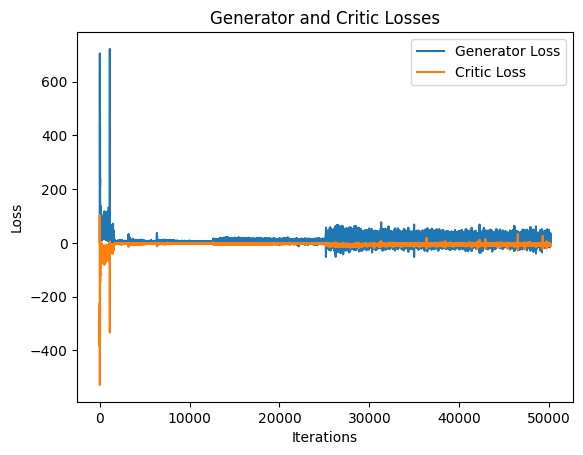

In [ ]:
def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen
):
    loop = tqdm(loader, leave=True)

    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]
        noise = torch.randn(cur_batch_size, Z_DIM).to(DEVICE)
        fake = gen(noise, alpha, step)

        # Critic loss
        critic_real = critic(real, alpha, step)
        critic_fake = critic(fake.detach(), alpha, step)
        gp = gradient_penalty(critic, real, fake, alpha, step, DEVICE)
        loss_critic = (
            -(torch.mean(critic_real) - torch.mean(critic_fake))
            + LAMBDA_GP * gp
            + 0.001 * torch.mean(critic_real ** 2)
        )
        critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()
        loss_critic_list.append(loss_critic.item())

        # Generator loss
        gen_fake = critic(fake, alpha, step)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        loss_gen_list.append(loss_gen.item())

        alpha += cur_batch_size / (
            PROGRESSIVE_EPOCHS[step] * 0.5 * len(dataset)
        )
        alpha = min(alpha, 1)

        loop.set_postfix(
            gp=gp.item(),
            loss_critic=loss_critic.item()
        )
    return alpha

def compute_fid_score(gen, real_loader, step, num_images=5000, batch_size=50):
    fid = FrechetInceptionDistance(feature=2048, normalize=True).to(DEVICE)
    gen.eval()
    alpha = 1.0  # Use full contribution from the new block

    # Collect real images
    num_real_images = 0
    with torch.no_grad():
        for real_batch, _ in tqdm(real_loader, desc='Collecting real images'):
            real_batch = real_batch.to(DEVICE)
            remaining_images = num_images - num_real_images
            if real_batch.size(0) > remaining_images:
                real_batch = real_batch[:remaining_images]
            fid.update(real_batch, real=True)
            num_real_images += real_batch.size(0)
            if num_real_images >= num_images:
                break

    # Generate fake images
    num_fake_images = 0
    while num_fake_images < num_images:
        current_batch_size = min(batch_size, num_images - num_fake_images)
        with torch.no_grad():
            noise = torch.randn(current_batch_size, Z_DIM).to(DEVICE)
            fake_batch = gen(noise, alpha, step)
            fid.update(fake_batch, real=False)
            num_fake_images += fake_batch.size(0)

    fid_score = fid.compute().item()
    gen.train()
    return fid_score

def compute_ppl(gen, step, num_samples=10000, eps=1e-4, batch_size=10):
    loss_fn = lpips.LPIPS(net='vgg').to(DEVICE)
    gen.eval()
    distances = []
    n_batches = num_samples // batch_size
    alpha = 1.0  # Use full contribution from the new block
    for _ in tqdm(range(n_batches), desc='Computing PPL'):
        z1 = torch.randn(batch_size, Z_DIM).to(DEVICE)
        z2 = z1 + eps * torch.randn_like(z1).to(DEVICE)
        with torch.no_grad():
            img1 = gen(z1, alpha, step)
            img2 = gen(z2, alpha, step)
        dist = loss_fn(img1, img2)
        distances.append(dist.view(-1))
    distances = torch.cat(distances)
    ppl_score = (distances ** 2).mean().sqrt().item() / (eps ** 2)
    gen.train()
    return ppl_score


def generate_examples(gen, steps, n=100, grid_size=(10, 10)):
    gen.eval()
    alpha = 1.0
    generated_images = []

    for i in range(n):
        with torch.no_grad():
            # Generate random noise
            noise = torch.randn(1, Z_DIM).to(DEVICE)
            img = gen(noise, alpha, steps)

            # Rescale the image to [0, 1] for saving and displaying
            img_rescaled = (img + 1) / 2  # Normalize from [-1, 1] to [0, 1]

            # Clip values to ensure they're within [0, 1]
            img_rescaled = img_rescaled.clamp(0, 1)

            # Save the image
            if not os.path.exists(f'saved_examples/step{steps}'):
                os.makedirs(f'saved_examples/step{steps}')
            save_image(img_rescaled, f"saved_examples/step{steps}/img_{i}.png")

            # Collect the image for displaying
            generated_images.append(img_rescaled.squeeze(0))

    # Display images in a grid
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 15))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i in range(len(generated_images)):
        ax = axes[i]
        # Convert tensor to HWC format (Height, Width, Channels) for displaying
        ax.imshow(np.transpose(generated_images[i].cpu().numpy(), (1, 2, 0)))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    gen.train()

# Model Initialization
gen = Generator(Z_DIM, W_DIM, IN_CHANNELS, CHANNELS_IMG).to(DEVICE)
critic = Discriminator(IN_CHANNELS, CHANNELS_IMG).to(DEVICE)

# Optimizers
opt_gen = optim.Adam(
    [
        {'params': [param for name, param in gen.named_parameters() if 'map' not in name]},
        {'params': gen.map.parameters(), 'lr': 1e-5}
    ],
    lr=LEARNING_RATE, betas=(0.0, 0.99)
)
opt_critic = optim.Adam(
    critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99)
)

# Progressive Training
gen.train()
critic.train()
step = int(log2(START_TRAIN_IMG_SIZE / 4))

# CSV file setup
csv_file_path = "fid_scores.csv"
header = ["Step", "FID Score"]

# Write header to CSV
with open(csv_file_path, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(header)

for num_epochs in PROGRESSIVE_EPOCHS[step:]:
    alpha = 1e-7
    loader, dataset = get_loader(4 * 2 ** step)
    print(f"Current image size: {4 * 2 ** step}")

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        alpha = train_fn(
            critic, gen, loader, dataset, step, alpha, opt_critic, opt_gen
        )

    # Generate examples after each step
    generate_examples(gen, step)

    # Compute and log FID and PPL
    # Compute FID
    fid_score = compute_fid_score(gen, loader, step)
    print(f"FID score at step {step}: {fid_score}")
    with open("fid_scores.txt", "a") as f:
        f.write(f"Step {step}: FID = {fid_score}\n")

    # Append to CSV file
    with open(csv_file_path, mode="a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([step, fid_score])

    step += 1

print(f"FID scores saved to {csv_file_path}.")

# Save the models
torch.save(gen.state_dict(), "generator.pth")
torch.save(critic.state_dict(), "discriminator.pth")
print("Models saved!")

# Plot the losses
plt.figure()
plt.plot(loss_gen_list, label="Generator Loss")
plt.plot(loss_critic_list, label="Critic Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Generator and Critic Losses")
plt.legend()
plt.savefig("loss_plot.png")
plt.show()

In [ ]:
# Save the generator and discriminator models
torch.save({
    'generator_state_dict': gen.state_dict(),
    'critic_state_dict': critic.state_dict(),
    'opt_gen_state_dict': opt_gen.state_dict(),
    'opt_critic_state_dict': opt_critic.state_dict(),
    'step': step
}, 'stylegan_model.pth')

print("Model saved successfully.")

Model saved successfully.


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import os
import torch

In [16]:
# Specify the save directory
save_dir = "/content/"
config_path = os.path.join(save_dir, 'stylegan_model.pth')

config = torch.load(config_path, map_location=torch.device('cpu'))
DEVICE = torch.device('cpu')

<ipython-input-16-d68a7c37c3cb>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  config = torch.load(config_path, map_location=torch.device('cpu'))


In [20]:
Z_DIM = config["Z_DIM"]
W_DIM = config["W_DIM"]
IN_CHANNELS = config["IN_CHANNELS"]
CHANNELS_IMG = config["CHANNELS_IMG"]

# Load the generator model
generator_path = os.path.join(save_dir, 'generator.pth')
gen = Generator(
    z_dim=Z_DIM,
    w_dim=W_DIM,
    in_channels=IN_CHANNELS,
    img_channels=CHANNELS_IMG
).to(DEVICE)
gen.load_state_dict(torch.load(generator_path, map_location=DEVICE))
gen.eval()

# training step
step_path = os.path.join(save_dir, 'stylegan_model.pth')
step = torch.load(step_path, map_location=DEVICE)

# test dataset
dataset_dir = '/content/drive/MyDrive/test_lab2'
test_loader, _ = get_loader(image_size=256, dataset_dir=dataset_dir)

# Computing FID Score
fid_score = compute_fid_score(gen, test_loader, step, num_images=10, batch_size=256)
print(f"FID Score: {fid_score}")

FID Score: 35.43425369262695


# FID Score for all the steps

- Step : 0 --> FID Score: 67.38048553466797
- Step : 1 --> FID Score: 50.43729782104492
- Step : 2 --> FID Score: 55.1697883605957
- Step : 3 --> FID Score: 51.26017379760742
- Step : 4 --> FID Score: 35.43425369262695
- Step : 5 --> FID Score: 15.576030731201172
